# PLSDA Cancer Classification on GBM Cell Lines

### Import data from csv

In [19]:
import numpy as np
import csv
import time
import scipy
from scipy import stats
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt

# PARSING DATA
After performing preprocessing on our images, the input data for this program will be a '.csv' file. The following code parses the data in that file and stores it into two arrays. X will be the array that contains the pixel color values for all of the pixels in all 100 of our images. Y will be the array which lists the label (0) mes or (1) pro for each of the cell images. 

In [20]:
# csv_filename = '/Users/chiara.mooney/Desktop/new_data.csv'
csv_filename = '/Users/Ryan/Dropbox/Sharing/project data/128_data.csv'
# csv_filename = 'D:/Ryan/Dropbox/Sharing/project data/128_data.csv'

data = []

with open(csv_filename, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        data.append(row[1:])
        
data = np.array(data)

X = data[:, 0:-1]
Y = data[:, -1]
X = X.astype(int)
Y = Y.astype(int)

print(Y)

# normalize data
x_zscore = scipy.stats.mstats.zscore(X, axis=0)
Y_mean = np.mean(Y)
Y_std = np.std(Y)
y_zscore = scipy.stats.zscore(Y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [21]:
# Print data shape
print("Inputs matrix size: {}".format(X.shape))
print("Outputs matrix size: {}".format(Y.shape))
print("\n\n")

print("Completed at: {}".format(time.time()))

Inputs matrix size: (182, 16383)
Outputs matrix size: (182,)



Completed at: 1552266375.589492


# EXAMINING DATA
Let's take a look at the data we are working with. Based on our earlier results we have chosen to use 2 PCs. Let's build our scores and loadings plot so we can better examine our data set in connection to these principle components. 

In [22]:
plsda = PLSRegression(n_components=2)
plsda.fit(x_zscore,y_zscore)

PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)

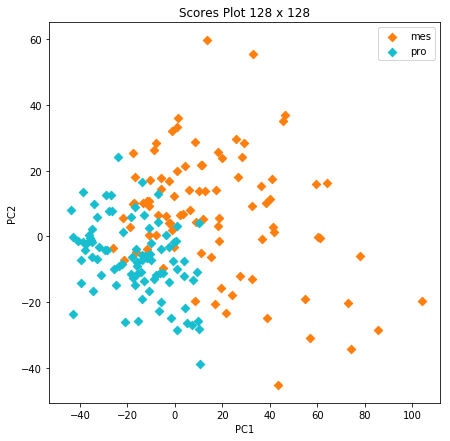

In [23]:
scores_PC1 = plsda.x_scores_[:, 0]
scores_PC2 = plsda.x_scores_[:, 1]

num_inputs = X.shape[0]//2

plt.figure(figsize =(7,7))
plt.title("Scores Plot 128 x 128")
plt.scatter(scores_PC1[0:num_inputs - 1], scores_PC2[0:num_inputs - 1], c='tab:orange',marker='D', label="mes")
plt.scatter(scores_PC1[num_inputs:], scores_PC2[num_inputs:], c='tab:cyan',marker='D', label="pro")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

In [24]:
# x_loadings_PC1 = plsda.x_loadings_[:, 0]
# x_loadings_PC2 = plsda.x_loadings_[:, 1] 

# y_loadings_PC1 = plsda.y_loadings_[:, 0]
# y_loadings_PC2 = plsda.y_loadings_[:, 1] 

# y_weights_PC1  = plsda.y_weights_[:,0]
# y_weights_PC2  = plsda.y_weights_[:,1]

# # we are looking to plot w*c
# # first lets find w*, where w* = w(p'w)^-1

# wStar =(np.matmul(plsda.x_weights_, np.linalg.inv(np.matmul(plsda.x_loadings_.T, plsda.x_weights_))))

# x_wStar_PC1  = wStar[:,0]
# x_wStar_PC2  = wStar[:,1]

# plt.figure(figsize=(4, 4), dpi=100)

# # need to scale 
# plt.scatter(0.15*y_loadings_PC1,0.15*y_loadings_PC2, c='b', label = "Response") 
# plt.scatter(np.multiply(x_wStar_PC1, y_weights_PC1), np.multiply(x_wStar_PC2, y_weights_PC2), c='y', label="Signals")
# plt.legend()
# plt.title("PC1 vs PC2 -- Loadings Plot")
# plt.xlabel("PC1")
# plt.ylabel("PC2")

# PERFORMING PLSDA
Now that we have processed our csv file and correctly stored our oberservations into an array, we will begin to construct our model using PLSDA. After doing some research online we discovered a method for implementing PLSDA via PLSR. We will build a model using PLSR, where our yobs is an array of 0s (mesanchymal) or 1s (proneural). PLSR will make predictions which will result in continous values from 0 to 1. However, we need our data to be discrete so that we can correctly classify each image into a cell type. Thus, following PLSR we will need to threshold our ypred.

#### Calculation of R2X and R2Y
This will be used to determin how many primary components to use

91.3128947846 % of variation for y accounted for using 7 PCs.


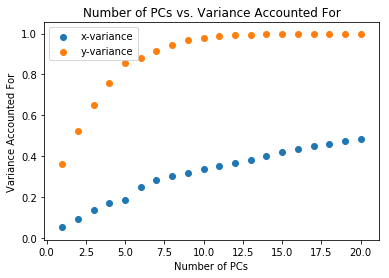

Completed at: 1552266384.170134


In [25]:
import scipy as sp, numpy as np
import scipy.io as sio
from sklearn.preprocessing import scale, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import LeaveOneGroupOut, LeaveOneOut
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

import scipy
from scipy import stats



X_R2_data = []
Y_R2_data = []

def make_params_R2 (scores, loadings, observed):
    loadings_transpose = np.ndarray.transpose(loadings)
    x_model = np.squeeze(np.dot(scores, loadings_transpose))
    # when is squeeze necessary
    return (R2(x_model, observed))

def R2 (x_model, observed):
    sum_sq_err = np.sum(np.square(np.squeeze(np.subtract(x_model, observed))))
    sq_obs = np.sum(np.square(observed))
    return 1 - (sum_sq_err/sq_obs)

max_pcs = 20
reach_90_x = False
reach_90_y = False

for i in range(max_pcs):
    pls= PLSRegression(n_components=(i+1))
    pls.fit(x_zscore,y_zscore)
    new_R2_X = make_params_R2(pls.x_scores_, pls.x_loadings_, x_zscore)
    X_R2_data.append(new_R2_X)
    if (new_R2_X > 0.9) and not reach_90_x:
        print((100*new_R2_X), "% of variation for x accounted for using",(i+1), "PCs.")
        reach_90_x = True
    
    Y_model = np.squeeze(pls.predict(x_zscore))
    new_R2_Y = R2(Y_model, y_zscore)
    Y_R2_data.append(new_R2_Y)
    if (new_R2_Y > 0.9) and not reach_90_y:
        print((100*new_R2_Y), "% of variation for y accounted for using", (i+1), "PCs.")
        reach_90_y = True

#plt.figure(figsize =(1300,80), dpi=100)
plt.title("Number of PCs vs. Variance Accounted For")
plt.scatter(np.arange(1,max_pcs+1), X_R2_data, label="x-variance")
plt.scatter(np.arange(1,max_pcs+1), Y_R2_data, label="y-variance")
plt.xlabel("Number of PCs")
plt.ylabel("Variance Accounted For")
plt.legend()
plt.show()

print("Completed at: {}".format(time.time()))

#### Leave One Out Cross Validation
Perform LOO cross validation on our model to evaluate the predicted error of our model

In [26]:
# build model and run LOO cross validation
num_of_comp = 6
loo = LeaveOneOut()

Y_raw_loo = []
Y_test_loo = []
pls_loo = PLSRegression(n_components=(num_of_comp))

for train_index, test_index in loo.split(X, Y):
    
    pls_loo.fit_transform(X[train_index], Y[train_index])
    pls_loo.transform(X[test_index])
    new_y_pred = pls_loo.predict(X[test_index])
    Y_raw_loo.append(np.squeeze(new_y_pred))
    Y_test_loo.append((Y[test_index]))
    
print("Completed at: {}".format(time.time()))

Completed at: 1552266420.030656


In [36]:
# threshold our results to parse our data into two categories: (0) mes and (1) pro
Y_predict_loo = []
num_inputs = X.shape[0]

raw_pred_mean = np.mean(Y_raw_loo)

for i in range(num_inputs):
    print(Y_raw_loo[i])
    if Y_raw_loo[i] >= raw_pred_mean:
        Y_predict_loo.append(np.squeeze(1))
    else:
        Y_predict_loo.append(np.squeeze(0))
    
np.squeeze(Y_predict_loo)
np.squeeze(Y_test_loo)

# count number of correct predictions made by our model
mes_correct = 0
mes_false_pos = 0
pro_false_pos = 0
pro_correct = 0
for i in range(num_inputs):
    if (Y_predict_loo[i] == Y_test_loo[i]):
        if Y_predict_loo[i] == 0:
            mes_correct += 1
        else:
            pro_correct += 1
    elif (Y_predict_loo[i] != Y_test_loo[i]):
        if Y_predict_loo[i] == 0:
            mes_false_pos += 1
        else:
            pro_false_pos += 1
print("LOO Cross Validation Results [128 CASE]:")
print("mes cells correctly predicted: ", mes_correct)
print("mes cells incorrecly predicted: ", mes_false_pos)
print("pro cells correctly predicted: ", pro_correct)
print("pro cells incorrectly predicted: ", pro_false_pos)

0.37221872151880236
0.6357319580333082
0.3898629003426119
1.2542494146942262
0.2323069087440432
1.0549263537992697
0.8417611500658523
-0.665374902008624
0.7935002105332916
0.8409840483727926
0.7248475475594867
0.4565033676337418
0.5070212636376318
0.7448423086706908
0.050231805573783594
0.7439721614782746
1.0127589602425877
0.022878133645674648
0.3497627321263512
0.8377641565742119
0.1709207420566553
0.5182640270948906
0.7566920883126254
-0.6746717305477378
0.4819262926264122
0.5235796454197541
0.22628643841401797
0.5784871002976453
0.16534969363522695
-1.2554239031686016
0.3709563937380598
-1.1744244884209634
1.0926602314405178
0.47235497895761086
1.0802970312586404
0.9543022032031749
-0.4689712628444307
1.2226500913996623
0.447799414081739
0.7521208071449986
0.09481281498785099
0.2027860781158699
0.7260593662767851
0.7558262742063508
0.4112483764007958
-0.0010825104432076182
0.3599839052140483
0.07616379743630275
0.9256375243859349
1.0433539252597461
0.7818545955179506
0.571275539232

#### K-Fold Crossvalidation
Run K-fold with 5-10 observations held out to compare with performance of LOOCV

In [28]:
num_of_comp = 6
logo = LeaveOneGroupOut()

group_size = 8
groups = []
for i in range(X.shape[0]):
    groups.append(i % group_size)
groups = np.array(groups)

X = np.array(X)
Y = np.array(Y)
X = X.astype(float)

Y_raw_preds = []
Y_test_logo = []
pls_logo = PLSRegression(n_components=(num_of_comp))

for train_index, test_index in logo.split(X, groups=groups):
    X_train = X[train_index]
    Y_train = Y[train_index]
    
    # Scale
    scaler = StandardScaler()
    X_train_zs = scaler.fit_transform(X_train)
    X_test_zs = scaler.transform(X[test_index])
    
    # Fit model
    pls_logo.fit(X_train_zs, Y_train)
    Y_test_pred = pls_logo.predict(X_test_zs)
    Y_raw_preds.append(np.squeeze(np.array(Y_test_pred)))
    Y_test_logo.append(Y[test_index])
    
    # Log
    # print(np.squeeze(np.array(Y_test_pred)))
    # print(Y[test_index])




In [29]:
# Manually flatten
Y_test_logo_flat = []
for i in range(len(Y_test_logo)):
    for j in range(len(Y_test_logo[i])):
        Y_test_logo_flat.append(Y_test_logo[i][j])
        
Y_raw_preds_flat = []
for i in range(len(Y_raw_preds)):
    for j in range(len(Y_raw_preds[i])):
        Y_raw_preds_flat.append(Y_raw_preds[i][j])
        
Y_test_logo_flat = np.array(Y_test_logo_flat)
Y_raw_preds_flat = np.array(Y_raw_preds_flat)

print(Y_raw_preds_flat.shape)
print(Y_test_logo_flat.shape)
print("Completed at: {}".format(time.time()))

(182,)
(182,)
Completed at: 1552266421.934921


In [30]:
Y_class_preds = []
num_inputs = X.shape[0]

for i in range(num_inputs):
    if Y_raw_preds_flat[i] >= 0.45:
        Y_class_preds.append(1)
    else:
        Y_class_preds.append(0)

print(Y_class_preds)   
print(Y_test_logo_flat)   

mes_correct = 0
mes_false_pos = 0
pro_false_pos = 0
pro_correct = 0
for i in range(num_inputs):
    if (Y_predict_loo[i] == Y_test_loo[i]):
        if Y_predict_loo[i] == 0:
            mes_correct += 1
        else:
            pro_correct += 1
    elif (Y_predict_loo[i] != Y_test_loo[i]):
        if Y_predict_loo[i] == 0:
            mes_false_pos += 1
        else:
            pro_false_pos += 1



print("{}-Fold Crossvalidation Results [128 CASE]:".format(group_size))
print("mes cells correctly predicted: ", mes_correct)
print("mes cells incorrecly predicted: ", mes_false_pos)
print("pro cells correctly predicted: ", pro_correct)
print("pro cells incorrectly predicted: ", pro_false_pos)


print("Completed at: {}".format(time.time()))

[0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1]
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
8-Fold Crossvalidation Results [128 CASE]:
mes cells correctly predicted:  38
mes c

#### Random Model Control
Build set of predictions made by the random choice of 0 or 1. Use the accuracy of this model to serve as a baseline for our PLSDA model. If our PLSDA model does better than random, we have a success.

In [31]:
# build data set of random values from [0,1]
Y_random = []
num_inputs = X.shape[0]


for i in range(num_inputs):
    Y_random.append(np.random.randint(0,2))
Y_random = np.array(Y_random)

mes_correct = 0
mes_false_pos = 0
pro_false_pos = 0
pro_correct = 0

# evaluate success of random prediction
for i in range(num_inputs):
    if (Y_random[i] == Y[i]):
        if Y_random[i] == 0:
            mes_correct += 1
        else:
            pro_correct += 1
    elif (Y_random[i] != Y[i]):
        if Y_random[i] == 0:
            mes_false_pos += 1
        else:
            pro_false_pos += 1
            
print("Random Prediction Results: ")
print("mes cells correctly predicted: ", mes_correct)
print("mes cells incorrecly predicted: ", mes_false_pos)
print("pro cells correctly predicted: ", pro_correct)
print("pro cells incorrectly predicted: ", pro_false_pos)


Random Prediction Results: 
mes cells correctly predicted:  45
mes cells incorrecly predicted:  46
pro cells correctly predicted:  45
pro cells incorrectly predicted:  46
